# Stochastic function optimization using NN as a model
Our goal is to optimize a stochastic function, i.e. a function which is not known in closed form. The only way to _know_ the function is to make measurements at different points in the definition space and get noisy results.

As alway in real life, measurements are not free, they cost something, so we want to get to a good optimum making as few measurements as possible.

To do this we use a model of the function, which in this case will be a neuronal network.

In [2063]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## A test function of 2 variables

This will be our _true_ function, which delivers the true values:

$ f(x, y) = 0.2 (x - 1) ^ 2 + 0.3 (y - 2) ^ 2 $

This function has a global minimum of 0 at x=1 and y=2, which we will try to reach.

In [2064]:
offset = np.asarray([1, 2])
qcoef = np.asarray([0.2, 0.3])

In [2065]:
def test_function_1(x):
    x1 = x - offset
    x2 = x1 * x1
    return np.dot(x2, qcoef)

Let's see how this function looks in the interest area

In [2066]:
x = np.linspace(-1, 3, 100)
y = np.linspace(0, 4, 100)
xx, yy = np.meshgrid(x, y)
z = np.stack([xx, yy], axis=-1)
zz = test_function_1(z)

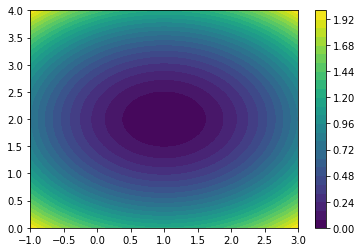

In [2067]:
fig, ax = plt.subplots()
cs = ax.contourf(xx, yy, zz, 32)
cbar = fig.colorbar(cs)
plt.show()

We will start our optimization from the origin.

In [2068]:
test_function_1(np.asarray([0, 0]))

1.3999999999999999

## Measurements are noisy
We want to simulate the noisy measurements of the real function values. So we define a function which will generate a bunch of noisy measurements around a given current point. The measurement points are chosen randomly.

The spread of the measurement points and the noise level (standard deviation) are given as parameters.

The function returns the measurement points and the measured values.

In [2069]:
cov = np.asarray([[1, 0], [0, 1]])

In [2070]:
def generate_measurements(n, x0, spread=1, level=1):
    x = np.random.multivariate_normal(x0, cov * spread, n)
    noise = np.random.randn(n) * level
    return x, test_function_1(x) + noise

In [2071]:
x, m = generate_measurements(3, [1, 1], 0.2, 0.1)
print('x:', x)
print('m:', m)

x: [[ 0.76554724  0.35282082]
 [ 1.46503963  0.83524481]
 [ 1.95884114  0.62827095]]
m: [ 0.79245369  0.50450843  0.75926013]


## The model
We use a feed-forward neuronal network as a model for our function.

When we make a few measurements, we collect training data for our model. We train the model for a few steps, then use it to make a small step in the direction that minimizes the model output (which will not be the same with the direction that minimizes the real function, because the model is imperfect).

In [2072]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout

Let's define some parameters used in the model (or training):

In [2073]:
INPUT_DIM = 2
drop = 0.25
lr_pred = 1e-4
lr_opt = 1e-3

For our simple function we chose a network with 5 dense hidden layers. After the first hidden layer we add a dropout layer, which will regularize the network. This is necessary to avoid overfitting of the parameters, which may occur at least in the beginning of the optimization, when our collected data volume is too small.

In [2074]:
inp = Input([INPUT_DIM], name='measure')
x = Dense(4 * INPUT_DIM, activation='relu')(inp)
x = Dropout(drop)(x)
x = Dense(2 * INPUT_DIM, activation='relu')(x)
x = Dense(2 * INPUT_DIM, activation='relu')(x)
x = Dense(1 * INPUT_DIM, activation='relu')(x)
x = Dense(1 * INPUT_DIM, activation='relu')(x)
out = Dense(1)(x)
network = Model(inputs=inp, outputs=out)

To train the model, we use the normal stochastic gradient descent optimizer. As this is a regression problem (as opposed to classification), we will use the mean squared error loss.

In [2075]:
sgd1 = keras.optimizers.SGD(lr=lr_pred)
network.compile(optimizer=sgd1, loss='mean_squared_error')

In [2076]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
measure (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_491 (Dense)            (None, 8)                 24        
_________________________________________________________________
dropout_71 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_492 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_493 (Dense)            (None, 4)                 20        
_________________________________________________________________
dense_494 (Dense)            (None, 2)                 10        
_________________________________________________________________
dense_495 (Dense)            (None, 2)                 6         
__________

## Using the NN model to optimize a function
Now let's say we have a model of our function, which will predict the value of the function for every given input. How do we find the optimum of the function?

We could choose a random search method, which could go like this:
1. select a few random points around the current best point
2. evaluate the model for that points
3. take the best of them as the new current best point
4. iterate 1 to 3 until some stop criterion is satisfied

But out model is differentiable! Let's use this fact to follow the gradient descent (or ascent, if we maximize) in order to minimize the model output.

To use this idea, we need a second Keras model, for the optimizer itself. In our second model, the network weights must remain fixed, and we need to _move_ the input (our current best point) in the correct direction.

In [2077]:
for layer in network.layers:
    layer.trainable = False

In [2078]:
x0 = np.asarray([[0, 0]], 'float32')
y0 = np.asarray([[0]], 'float32')

This is the tricky part.

In a Keras model, we can't _optimize_ the input. We can only optimize parameters. So we define our current best point in a new layer, called current_x_layer, which is a dense layer.

A dense layer has 2 parameters, a weights matrix and a bias, so the formula of the output is:

$ y = W x + b $

Our current point is a vector, so we can store it in the bias parameter of the dense layer. Now, when we _train_ the optimizer, we will always give 0 as input and will get b as output, our current best point.

Now we feed this into our network to calculate the model output. Backpropagation will calculate the gradient of the input with respect to our trainable parameters, which are W and b. These parameter will be updated towards a better output value. (Updating W is just colateral damage. We could design our own layer to avoid this unnecessary calculation, see [here](https://keras.io/layers/writing-your-own-keras-layers/). This is left as an exercise for the reader.)

In [2079]:
fake_inp = Input([1])
current_x_layer = Dense(INPUT_DIM, bias_initializer=keras.initializers.Constant(value=x0))
current_x = current_x_layer(fake_inp)

In [2080]:
current_y = network(current_x)
optimizer = Model(inputs=fake_inp, outputs=current_y)

In [2081]:
sgd2 = keras.optimizers.SGD(lr=lr_opt)
optimizer.compile(optimizer=sgd2, loss='mean_squared_error')

In [2082]:
optimizer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_497 (Dense)            (None, 2)                 4         
_________________________________________________________________
model_141 (Model)            (None, 1)                 99        
Total params: 103
Trainable params: 4
Non-trainable params: 99
_________________________________________________________________


## Optimizing
We will have an iterative process of 5 steps:
- generate a few noisy measurements around the current best x
- test the current model on them
- integrate the new measurements into the training data
- train a new model
- based on the new model take a step from current x to the next one (to minimize the given function)

In [2083]:
no_meas = 32
batch_size = 32
max_points = 102400
point_spread = 0.8
meas_sigma = 0.01
steps = 500
opt_steps = 100
pre_steps = 200

### Training data accumulates
Here is all we need to accumulate training data and generate training batches:

In [2084]:
train_x = None
train_y = None
permut = None
mse = []
tx = []
ty = []
tl = []
ol = []

When we integrate new measurements into the training data, we may whish to retain only a limited number of measumenets:
- to avoid keeping to many data in memory
- to train the model with data points from the near vicinity (as the new measurements are centered to the current best point)

In [2085]:
def integrate_train(tx, ty, x, y):
    if tx is None:
        tx = x
        ty = y
    else:
        tx = np.vstack((tx, x))[:max_points,]
        ty = np.vstack((ty, y))[:max_points,]
        
    per = np.random.permutation(tx.shape[0])
    return tx, ty, per

In [2086]:
def get_batch(k):
    i = k * batch_size % train_x.shape[0]
    p = permut[i : i + batch_size]
    return train_x[p,], train_y[p,]

In [2087]:
for step in range(steps):
    # Current optimization point
    xc = current_x_layer.get_weights()[1]
    tx.append(xc[0])
    ty.append(xc[1])
    if step % 10 == 0:
        print('Step', step, ', x:', xc[0], ', y:', xc[1])
    
    # Generate new measurements around it
    x, y = generate_measurements(no_meas, xc, point_spread, meas_sigma)
    y = np.reshape(y, (no_meas, 1))
    
    # Test the old model on the new measurements
    p_loss = network.evaluate(x, y, verbose=0)
    mse.append(p_loss)
    
    # Integrate new point to the training set
    train_x, train_y, permut = integrate_train(train_x, train_y, x, y)
    
    # Train a new model
    for k in range(pre_steps):
        x, y = get_batch(k)
        t_loss = network.train_on_batch(x, y)
        tl.append(t_loss)
    
    # Make steps to the new optimum
    for k in range(opt_steps):
        o_loss = optimizer.train_on_batch(y0, y0)
        ol.append(o_loss)

Step 0 , x: 0.0 , y: 0.0
Step 10 , x: 0.0538534 , y: 0.00586044
Step 20 , x: 0.106096 , y: 0.312595
Step 30 , x: 0.0687025 , y: 0.607894
Step 40 , x: 0.00240072 , y: 0.97058
Step 50 , x: 0.0239708 , y: 1.1947
Step 60 , x: 0.0458391 , y: 1.31306
Step 70 , x: 0.0120406 , y: 1.41819
Step 80 , x: -0.0136253 , y: 1.51404
Step 90 , x: -0.0318487 , y: 1.5386
Step 100 , x: -0.0444215 , y: 1.5676
Step 110 , x: -0.0546668 , y: 1.5932
Step 120 , x: -0.0639677 , y: 1.63469
Step 130 , x: -0.0732031 , y: 1.6923
Step 140 , x: -0.0808599 , y: 1.7498
Step 150 , x: -0.0880546 , y: 1.80084
Step 160 , x: -0.0925442 , y: 1.84508
Step 170 , x: -0.100406 , y: 1.89193
Step 180 , x: -0.100488 , y: 1.9151
Step 190 , x: -0.102564 , y: 1.93955
Step 200 , x: -0.106723 , y: 1.96177
Step 210 , x: -0.10499 , y: 1.98129
Step 220 , x: -0.10667 , y: 2.00042
Step 230 , x: -0.10869 , y: 2.02292
Step 240 , x: -0.11248 , y: 2.04227
Step 250 , x: -0.114121 , y: 2.05877
Step 260 , x: -0.112736 , y: 2.07135
Step 270 , x: -0.10

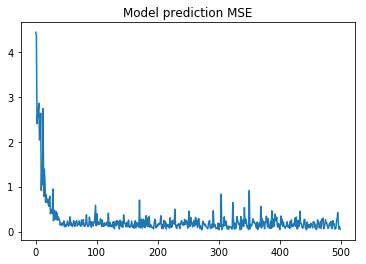

In [2088]:
plt.plot(mse)
plt.title('Model prediction MSE')
plt.show()

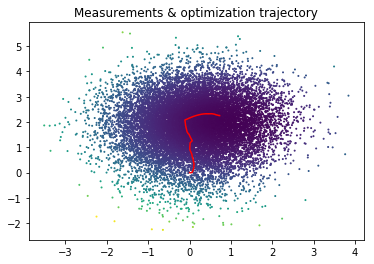

In [2089]:
plt.scatter(train_x[:, 0], train_x[:, 1], s=1, c=train_y)
plt.plot(tx, ty, 'r')
plt.title('Measurements & optimization trajectory')
plt.show()

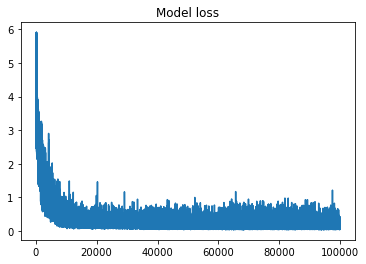

In [2090]:
plt.plot(tl)
plt.title('Model loss')
plt.show()

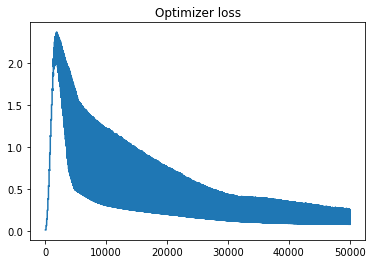

In [2091]:
plt.plot(ol)
plt.title('Optimizer loss')
plt.show()